## Calculating voter spectra
#### Performs MDS on the ballot data and outputs the candidates and voters positions on a single axis 


In [96]:
import os
import seaborn as sns
from scipy.stats import kurtosis, skew
import rcv_distribution as rcvdist
import rcv_dimensionality as rcvdim
import rcv_dist_weighted as rcvdw
import voting_rules as voru
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="mkl")

##### Extract the election data from a csv file

In [97]:
# Choose a csv with the election data
csv = os.path.join(os.getcwd(), '..', 'rcv_elections_database', 
                   'classic', 
                   #'Alaska_04102020_PRESIDENTOFTHEUNITEDSTATES.csv')
                   'Maine_11062018_CongressionalDistrict2.csv')

ballots, candidates = rcvdist.parse_election_data(csv)

##### Perform the RCV analysis

Notes:
- Made the 2d MDS calculation to optional because it was slowing code down substantially and would occasionally not finish when number of runs was large
- Added user parameters for n_init, max_iter, n_runs
- Did some testing of the effect of increasing n_init. As n_init gets larger, the fraction of mds runs that gives the lowest-stress result significantly increases. Increasing n_init enables us to do fewer runs to ensure we are getting the best solution. 
- Did some testing of the stability of the candidate coordinate positions returned for different runs, and these seem extremely stable within each order configuration

In [98]:
n_runs = 5 #00
n_init = 100 #0#
max_iter = 1000

(mds_1d_coordinates, 
mds_2d_coordinates, 
most_common_order, 
order_frequencies,
candidate_names)  = rcvdim.perform_rcv_analysis(csv, 
                                                n_init=n_init, 
                                                max_iter=max_iter,
                                                n_runs=n_runs, 
                                                calc_2d=False)

/Users/annie/Code/Repositories/bugs-in-democracy/EIL summer 2023/rcv_dimensionality.py:177: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


In [99]:
normalized_distances = rcvdim.get_distances_normalized(most_common_order, 
                                                       mds_1d_coordinates, 
                                                       candidate_names)
cn = np.array(candidate_names)
print("Most common order: ", cn[np.array(most_common_order).astype(int)])
print("Fraction in most common order: ", order_frequencies[0][1]/n_runs)

Most common order:  ['DEM Golden, Jared F.' 'Bond, Tiffany L.' 'Hoar, William R.S.'
 'REP Poliquin, Bruce']
Fraction in most common order:  1.0


##### Get the normalized distances between candidates and plot the MDS analysis

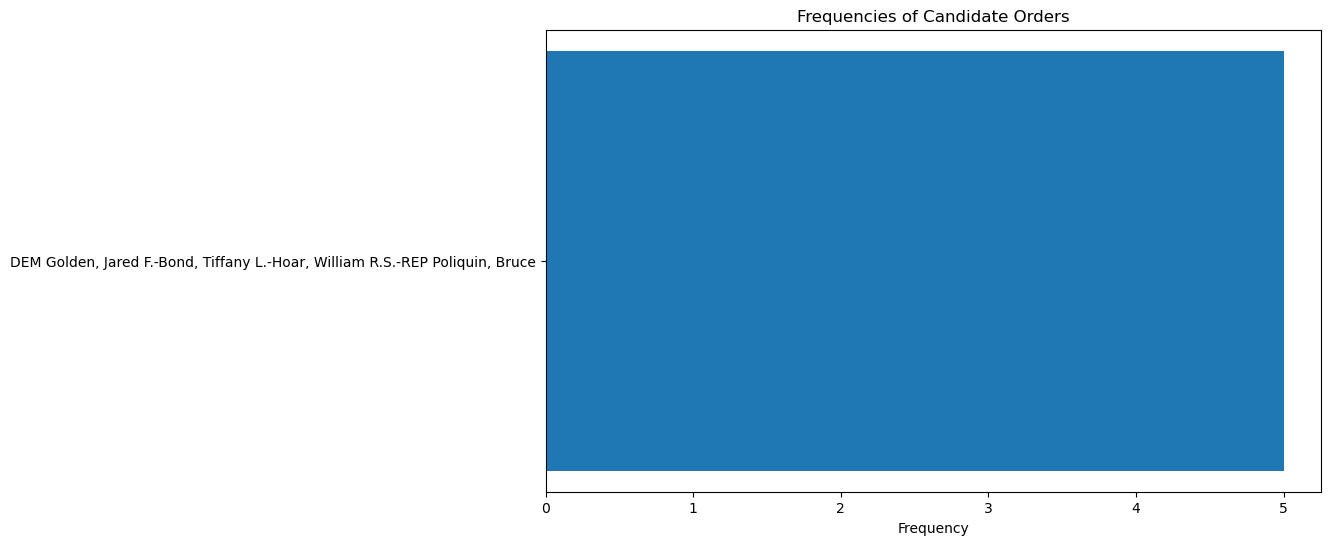

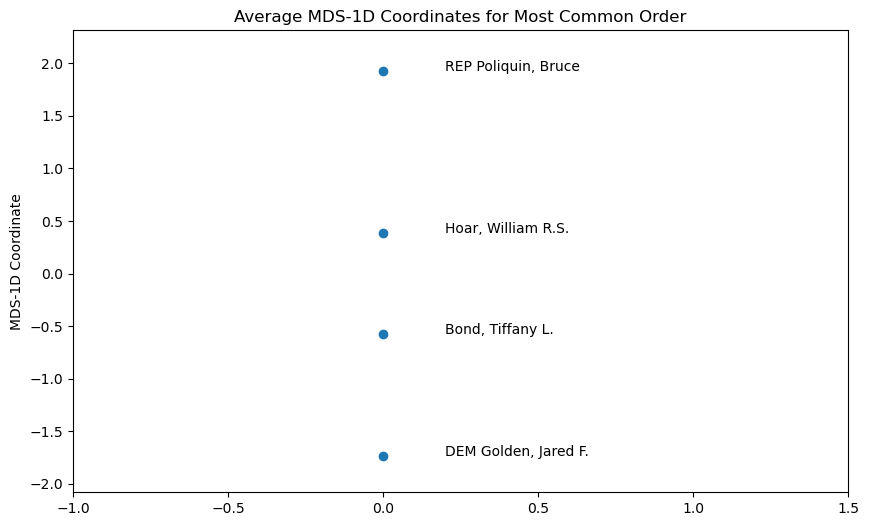

In [100]:
rcvdim.plot_rcv_analysis(mds_1d_coordinates, 
                         mds_2d_coordinates, 
                         most_common_order, 
                         order_frequencies, 
                         candidate_names)

##### Get the ballot points using the new weighted method

Notes:
- In this method, I find all the possible points for each given ballot, and distribute a weight for each ballot equally across all possible points, multiplied by the count of ballots of that ranking order.
- For ballots with only one candidate ranked, the full weight of the ballot is given to the point on the axis that corresponds to that candidate's position. 

In [122]:
# Convert the ballots to a numeric array
ballot_nums, candidate_names_order = rcvdw.ballot_names_to_nums(ballots, candidate_names, order_frequencies)

# Get the list of potential points for each adjacent candidate pair in the ballots
intervals, cand_coords = rcvdw.get_candidate_pair_intervals(ballot_nums, normalized_distances)

# get the coordinate points and weights that describe the ballot distribution
n_points = 503
points_all, weights_all = rcvdw.get_ballot_coords(ballots, intervals, cand_coords, n_points=n_points)

print('\n')
print(cand_coords)
for i in range(len(ballot_nums)):
    print('ballot order: ' + str(ballot_nums[i]))
    ballot_diff = np.diff(ballot_nums[i])
    print(np.sum((ballot_diff>1) & (ballot_diff<1000)))
    print('interval starts:' + str(intervals[0,i,:]))
    print('interval ends:' + str(intervals[1,i,:]))
    print('\n')



[0.         0.94592711 1.73312065 3.        ]
ballot order: [     3 100000 100000 100000]
0
interval starts:[2.36656033       -inf       -inf]
interval ends:[ 3. inf inf]


ballot order: [     0      1 100000 100000]
0
interval starts:[  0. -inf -inf]
interval ends:[0.47296356        inf        inf]


ballot order: [3 0 1 2]
0
interval starts:[1.5 0.  0. ]
interval ends:[3.         0.47296356 1.33952388]


ballot order: [2 3 1 0]
0
interval starts:[0.         1.97296356 0.47296356]
interval ends:[2.36656033 3.         3.        ]


ballot order: [100000 100000 100000 100000]
0
interval starts:[-inf -inf -inf]
interval ends:[inf inf inf]


ballot order: [0 1 2 3]
0
interval starts:[0. 0. 0.]
interval ends:[0.47296356 1.33952388 2.36656033]


ballot order: [3 2 1 0]
0
interval starts:[2.36656033 1.33952388 0.47296356]
interval ends:[3. 3. 3.]


ballot order: [2 1 3 0]
1
interval starts:[1.33952388 0.         1.5       ]
interval ends:[3.         1.97296356 3.        ]


ballot order: [

##### Get the ballot points using the old method

In [102]:
points = rcvdist.get_consistency_points(ballots, candidates, normalized_distances)

# Create a list of data points
data_points = []
for key, value in points.items():
    data_points.extend([key] * value)

# Convert to numpy array
data_points = np.array(data_points)

# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]

normalized_points = []
normalized_names = []
for name in normalized_distances:
    normalized_names.append(name)
    normalized_points.append(normalized_distances[name])


##### Plot

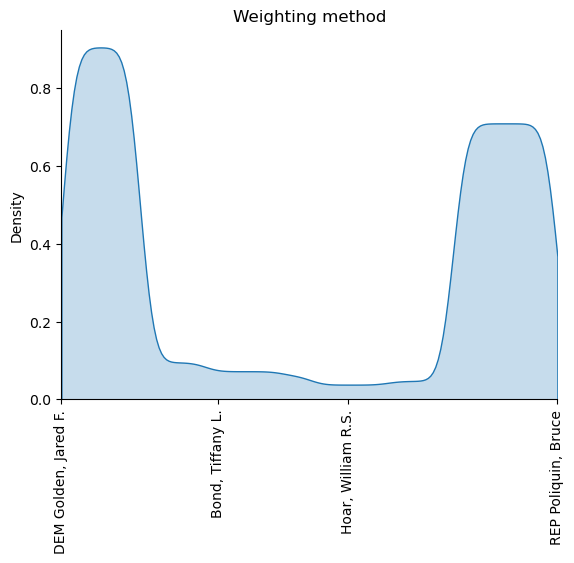

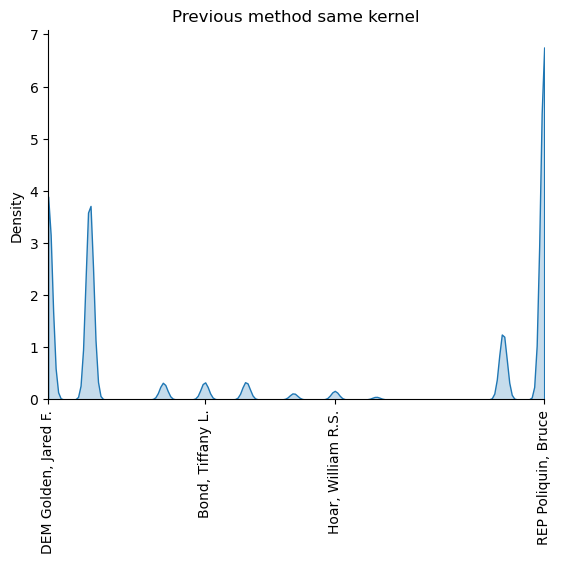

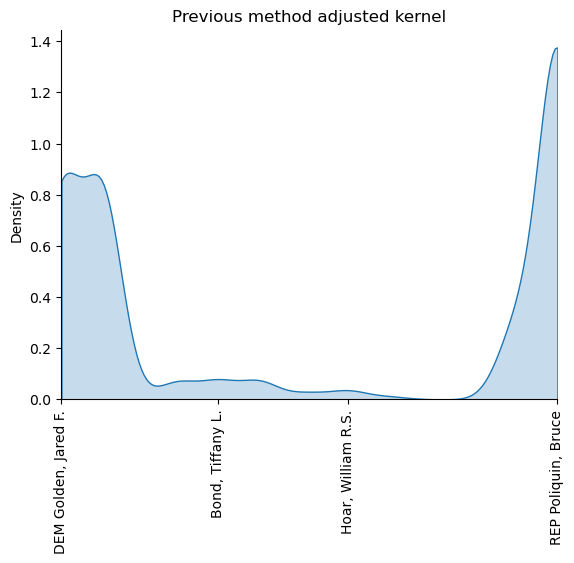

In [153]:
# Plot new kernal density estimation
data = pd.DataFrame({'points': points_all, 'weights': weights_all})
plt.xticks(cand_coords, candidate_names_order, rotation=90)
sns.kdeplot(data=data, x='points', weights='weights', fill=True, bw_adjust=.2, cut=0)
#sns.rugplot(data=data, x='points', alpha=0.05)
plt.title('Weighting method')
sns.despine()
plt.xlabel('')
plt.xlim([min(cand_coords), max(cand_coords)])

# Plot old kernal density estimation
plt.figure()
plt.title('Previous method same kernel')
sns.kdeplot(data_list, fill=True,bw_adjust=.2, cut=0)
#sns.rugplot(data=data_list, alpha=0.05)
plt.xticks(normalized_points, normalized_names, rotation=90)
plt.xlim([min(cand_coords), max(cand_coords)])
sns.despine()

# Plot old kernal density estimation
plt.figure()
plt.title('Previous method adjusted kernel')
sns.kdeplot(data_list, fill=True,bw_adjust=1, cut=0)
#sns.rugplot(data=data_list, alpha=0.05)
plt.xticks(normalized_points, normalized_names, rotation=90)
plt.xlim([min(cand_coords), max(cand_coords)])
sns.despine()

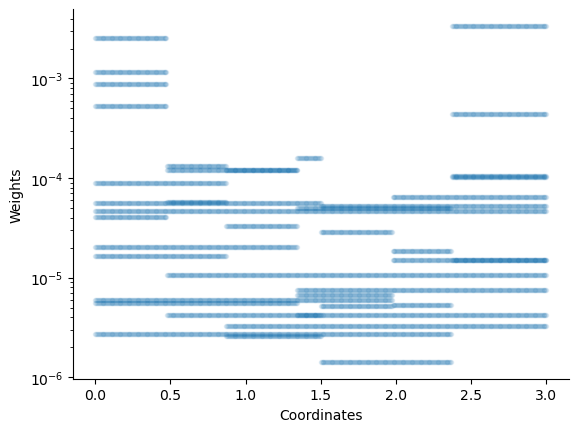

In [150]:
plt.semilogy(points_all, weights_all, '.', alpha=0.1)
plt.ylabel('Weights')
plt.xlabel('Coordinates')
sns.despine()

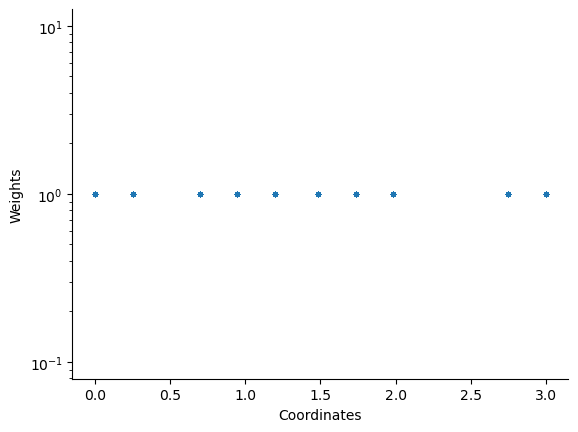

In [158]:
plt.semilogy(data_list, np.ones(len(data_list)), '.', alpha=0.01)
plt.xlabel('Coordinates')
plt.ylabel('Weights')
sns.despine()